In [54]:
import numpy as np
import matplotlib.pyplot as plt

from dask.distributed import Client

from ase.build import bulk
from abtem import FrozenPhonons, SMatrix, Potential, GridScan, AnnularDetector

import os
os.environ["MKL_NUM_THREADS"] = "1"

from abtem import config
config.set({'device': 'gpu'})
config.set({'lazy': True})

In [41]:
client = Client()

C:\Users\jacob\anaconda3\envs\abtem-dask-gpu\lib\site-packages\distributed\node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 56412 instead
  warnings.warn(


In [42]:
atoms = bulk('Si', 'diamond', a=5.43, cubic=True)
atoms *= (3, 3, 3)

In [49]:
# number of plane waves in each chunk
plane_wave_chunks = 32

# partioning of the griscan. The scattering matrix will be reduced in similarly partitioned chunks. Should be equal to or greater than the interpolation.
scan_partitions = (3, 3)

# Number of positions per reduction operation (single call to np.tensordot), 
# A large value reduces the number of required iterations in Python, but also increases the total number of FLOPS required
positions_per_reduction = 300

# Maximum number of scattering matrices in memory at any point
max_concurrent_s_matrices = 6

frozen_phonons = FrozenPhonons(atoms, 6, {'Si': .1})

potential = Potential(frozen_phonons, 
                      gpts=768,
                      projection='infinite', 
                      slice_thickness=.5)

probe = SMatrix(energy=200e3, semiangle_cutoff=20, chunks=plane_wave_chunks, interpolation=3, max_concurrent=max_concurrent_s_matrices)

scan = GridScan()

detectors = AnnularDetector(50, 150, ensemble_mean=False)

measurement = probe.scan(scan, 
                         detectors, 
                         potential,
                         scan_partitions=scan_partitions, 
                         positions_per_reduction=positions_per_reduction)

In [50]:
probe.build().array # just for showing the scattering matrix size

dask.array<concatenate, shape=(61, 768, 768), dtype=complex64, chunksize=(31, 768, 768), chunktype=numpy.ndarray>

<AxesSubplot:>

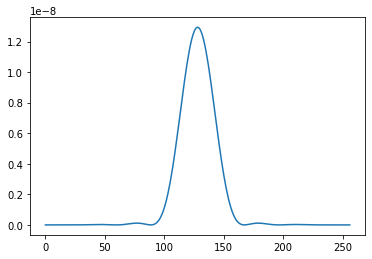

In [47]:
probe.profile().show()

In [51]:
%%time
measurement.compute()

Wall time: 1min 3s


(<AxesSubplot:xlabel='x [Å]', ylabel='y [Å]'>,
 <matplotlib.image.AxesImage at 0x26fda8b1070>)

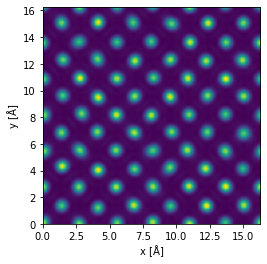

In [52]:
measurement.interpolate(.1).show()